# Implementation of a proposed model

## by Dedoria

## Data Description

### Dataset: Stroke Prediction Dataset

**Source**: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

**Research Question**: How do factors such as age, gender, hypertension, heart disease, and smoking status influence the likelihood of a patient having a stroke?

**About dataset & back ground**: Stroke is the leading cause of disability worldwide and the second leading cause of death. The ability to predict the likelihood of a stroke can provide crucial insights for medical professionals. The dataset provides information on various factors such as age, gender, hypertension, heart disease, and smoking status for each patient, along with whether they had a stroke. This data will be instrumental in answering the question of interest.

**Reading data**

In [9]:
# Run this cell before continuing.
library(moderndive)
library(tidyverse)
library(testthat)
library(ggplot2)
library(cowplot)
library(taxyvr)
library(digest)
library(infer)
library(broom)
library(dplyr)
library(leaps)
library(repr)

ERROR: Error in library(taxyvr): there is no package called ‘taxyvr’


**Reading Data**

In [19]:
# Reading data by using read_csv.
stroke_data <- read_csv("https://drive.google.com/uc?export=download&id=1O7k020r6eezRY5EPoFyF-FzAogsyOXIa")
# Preview the data.
head(stroke_data)

Rows: 5110 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): gender, ever_married, work_type, Residence_type, bmi, smoking_status
dbl (6): id, age, hypertension, heart_disease, avg_glucose_level, stroke

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id    gender age hypertension heart_disease ever_married work_type    
1  9046 Male   67  0            1             Yes          Private      
2 51676 Female 61  0            0             Yes          Self-employed
3 31112 Male   80  0            1             Yes          Private      
4 60182 Female 49  0            0             Yes          Private      
5  1665 Female 79  1            0             Yes          Self-employed
6 56669 Male   81  0            0             Yes          Private      
  Residence_type avg_glucose_level bmi  smoking_status  stroke
1 Urban          228.69            36.6 formerly smoked 1     
2 Rural          202.21            N/A  never smoked    1     
3 Rural          105.92            32.5 never smoked    1     
4 Urban          171.23            34.4 smokes          1     
5 Rural          174.12            24   never smoked    1     
6 Urban          186.21            29   formerly smoked 1

In [20]:
#tidy the data
stroke_data <- stroke_data %>% select(!id) %>% filter(!is.na(bmi))

head(stroke_data)

gender age hypertension heart_disease ever_married work_type    
1 Male   67  0            1             Yes          Private      
2 Female 61  0            0             Yes          Self-employed
3 Male   80  0            1             Yes          Private      
4 Female 49  0            0             Yes          Private      
5 Female 79  1            0             Yes          Self-employed
6 Male   81  0            0             Yes          Private      
  Residence_type avg_glucose_level bmi  smoking_status  stroke
1 Urban          228.69            36.6 formerly smoked 1     
2 Rural          202.21            N/A  never smoked    1     
3 Rural          105.92            32.5 never smoked    1     
4 Urban          171.23            34.4 smokes          1     
5 Rural          174.12            24   never smoked    1     
6 Urban          186.21            29   formerly smoked 1

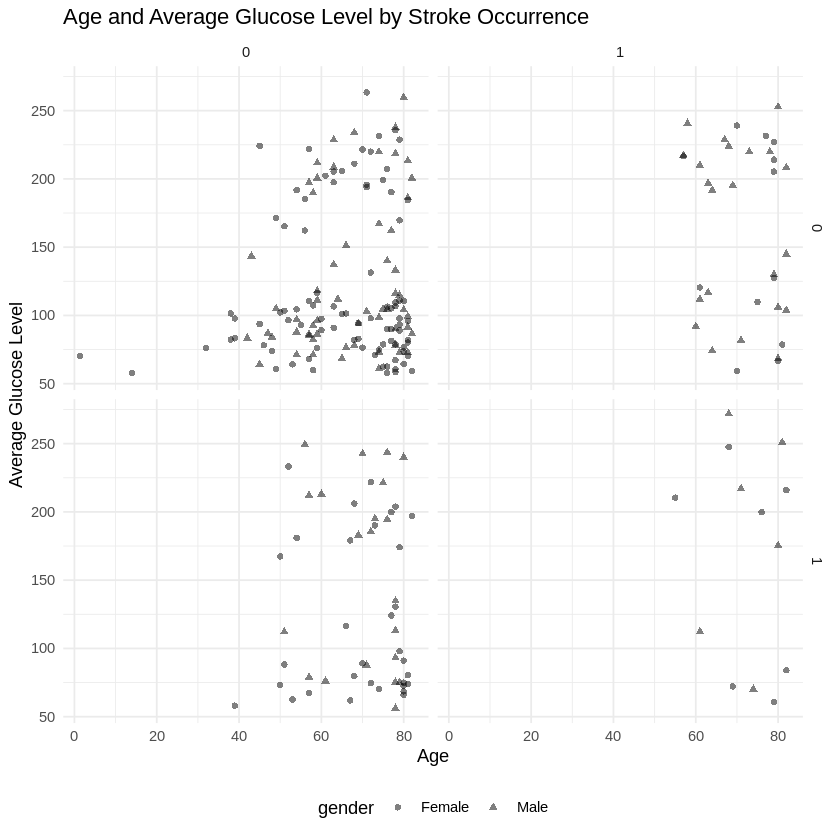

In [8]:
stroke_data <- stroke_data %>%
  mutate(
    stroke = as.factor(stroke), 
    hypertension = as.factor(hypertension), 
    heart_disease = as.factor(heart_disease) 
  ) %>% filter(stroke == 1)

# Now, let's create the combo plot
combo_plot <- ggplot(stroke_data, aes(x = age, y = avg_glucose_level, shape = gender)) +
  geom_point(alpha = 0.5) +
  facet_grid(hypertension ~ heart_disease) +
  labs(
    title = "Age and Average Glucose Level by Stroke Occurrence",
    x = "Age",
    y = "Average Glucose Level",
    size = "BMI"
  ) +
  theme_minimal() +
  theme(legend.position = "bottom")

combo_plot

## Stroke Occurrence Analysis

### Visualization Overview

The scatter plot below above shows the relationship between age, average glucose level, and stroke occurrence. It also considers additional factors such as hypertension, heart disease, and BMI.


### Insights from the Plot

- **Age and Glucose Level:** The plot shows a distribution of individuals by age and average glucose level, with stroke occurrences marked in a distinct color. This allows us to identify any patterns or clusters where strokes are more prevalent. 

- **Faceting by Condition:** By faceting the plot based on hypertension and heart disease status, we can compare these groups side by side. This comparison reveal there is a higher concentration of strokes among individuals without these conditions.

- **BMI as Point Size:** The size of each point corresponds to the individual's BMI. Larger points may indicate a higher BMI, which can be visually correlated with stroke occurrences to see if there is an association.

- **Gender as Point Shape:** It is incorporated as an additional aesthetic to explore gender differences in stroke occurrences. The occurance seems to be evenly distributed between two genders.

- **Transparency:** The use of transparency helps to mitigate the issue of overplotting, making it easier to see where data points are concentrated.

### How to intepret the graph
First grid: Individuals with neither hypertension nor heart disease (hypertension = 0, heart_disease = 0).

Second grid: Individuals with hypertension but no heart disease (hypertension = 1, heart_disease = 0).

Third grid: Individuals with heart disease but no hypertension (hypertension = 0, heart_disease = 1).

Fourth grid: Individuals with both hypertension and heart disease (hypertension = 1, heart_disease = 1).

### Trend in the graph
There is an obvious trend that elder people that is above 40 years old had a large chance to get stroke. The gender doesn't seems to be a very significant factor, because the occurance of stroke seems to be evenly distributed between two genders. 
For glucose level, lower glucose level without other health conditions seems to have higher probability to have stroke. People with at least on health condition seems to have higher chance to encounter stroke

### Relevance to Research Question

This visualization is particularly relevant to our research question: "How do factors such as age, gender, hypertension, heart disease, and smoking status influence the likelihood of a patient having a stroke?" It allows us to observe potential risk factors for stroke in a single view and to identify trends and outliers that may warrant further investigation. For instance, we can analyze whether older age groups or higher average glucose levels correlate with an increased risk of stroke and how this risk is potentially modified by the presence of hypertension or heart disease.


1. **Converting BMI to a categorical variable with less dummy variables**


In [21]:
stroke_data$bmi <- as.numeric(as.character(stroke_data$bmi))

# Handle any potential NA values that arise from conversion
stroke_data <- na.omit(stroke_data)

# Categorizing BMI into fewer groups
stroke_data$bmi_category <- cut(stroke_data$bmi,
                                breaks = c(0, 18.5, 24.9, 29.9, 39.9, 100),
                                labels = c("Underweight", "Normal", "Overweight", "Obese", "Severely Obese"),
                                right = FALSE)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


2. **Create a full model with every variables**

In [34]:
# Logistic Regression Model
model <- glm(stroke ~ age + gender + hypertension + heart_disease + avg_glucose_level + bmi_category + smoking_status, 
             data = stroke_data, family = "binomial")

# Summary of the model
summary(model)


Call:
glm(formula = stroke ~ age + gender + hypertension + heart_disease + 
    avg_glucose_level + bmi_category + smoking_status, family = "binomial", 
    data = stroke_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0897  -0.2952  -0.1574  -0.0738   3.6727  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -8.656763   1.110803  -7.793 6.53e-15 ***
age                          0.069222   0.005892  11.749  < 2e-16 ***
genderMale                  -0.008198   0.155593  -0.053  0.95798    
genderOther                 -7.329104 324.743880  -0.023  0.98199    
hypertension                 0.512594   0.174573   2.936  0.00332 ** 
heart_disease                0.368387   0.206277   1.786  0.07412 .  
avg_glucose_level            0.004654   0.001293   3.599  0.00032 ***
bmi_categoryNormal           0.952941   1.042329   0.914  0.36059    
bmi_categoryOverweight       0.911080   1.035340   0.880  0.378

3. **Too many insignificant covariates use backward selection to eliminate these variables**

In [24]:
model_with_out_gender <- glm(stroke ~ age + hypertension + heart_disease + 
                  avg_glucose_level + bmi_category + smoking_status, 
                  family = "binomial", data = stroke_data)


# Display the summary of the reduced model
summary(model_with_out_gender)


Call:
glm(formula = stroke ~ age + hypertension + heart_disease + avg_glucose_level + 
    bmi_category + smoking_status, family = "binomial", data = stroke_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0912  -0.2954  -0.1573  -0.0739   3.6739  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -8.660090   1.108661  -7.811 5.66e-15 ***
age                         0.069243   0.005886  11.764  < 2e-16 ***
hypertension                0.512538   0.174565   2.936 0.003324 ** 
heart_disease               0.367238   0.205132   1.790 0.073413 .  
avg_glucose_level           0.004649   0.001290   3.603 0.000314 ***
bmi_categoryNormal          0.952095   1.041347   0.914 0.360563    
bmi_categoryOverweight      0.909064   1.033730   0.879 0.379183    
bmi_categoryObese           0.925455   1.033165   0.896 0.370387    
bmi_categorySeverely Obese  1.059385   1.057178   1.002 0.316301    
smoking_statusnev

In [25]:
model_with_out_gender_and_smoke <- glm(stroke ~ age + hypertension + heart_disease + 
                  avg_glucose_level + bmi_category, family = "binomial", data = stroke_data)
# Display the summary of the reduced model
summary(model_with_out_gender_and_smoke)


Call:
glm(formula = stroke ~ age + hypertension + heart_disease + avg_glucose_level + 
    bmi_category, family = "binomial", data = stroke_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0945  -0.2943  -0.1605  -0.0774   3.5910  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -8.617411   1.086151  -7.934 2.12e-15 ***
age                         0.067902   0.005726  11.858  < 2e-16 ***
hypertension                0.529899   0.173868   3.048 0.002306 ** 
heart_disease               0.402845   0.203892   1.976 0.048180 *  
avg_glucose_level           0.004671   0.001290   3.621 0.000293 ***
bmi_categoryNormal          0.968612   1.039214   0.932 0.351305    
bmi_categoryOverweight      0.938773   1.031548   0.910 0.362790    
bmi_categoryObese           0.949987   1.030844   0.922 0.356757    
bmi_categorySeverely Obese  1.082179   1.054485   1.026 0.304767    
---
Signif. codes:  0 ‘***’ 0.001 

In [26]:
model_with_out_gender_smoke_bmi <- glm(stroke ~ age + hypertension + heart_disease + 
                  avg_glucose_level, family = "binomial", data = stroke_data)
# Display the summary of the reduced model
summary(model_with_out_gender_smoke_bmi)


Call:
glm(formula = stroke ~ age + hypertension + heart_disease + avg_glucose_level, 
    family = "binomial", data = stroke_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0995  -0.2940  -0.1599  -0.0778   3.5885  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -7.660740   0.387152 -19.787  < 2e-16 ***
age                0.067547   0.005571  12.124  < 2e-16 ***
hypertension       0.539613   0.173055   3.118 0.001820 ** 
heart_disease      0.404298   0.203447   1.987 0.046895 *  
avg_glucose_level  0.004802   0.001255   3.828 0.000129 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1728.4  on 4908  degrees of freedom
Residual deviance: 1374.6  on 4904  degrees of freedom
AIC: 1384.6

Number of Fisher Scoring iterations: 7


4. **Choose the final model with fewer variables but significant**

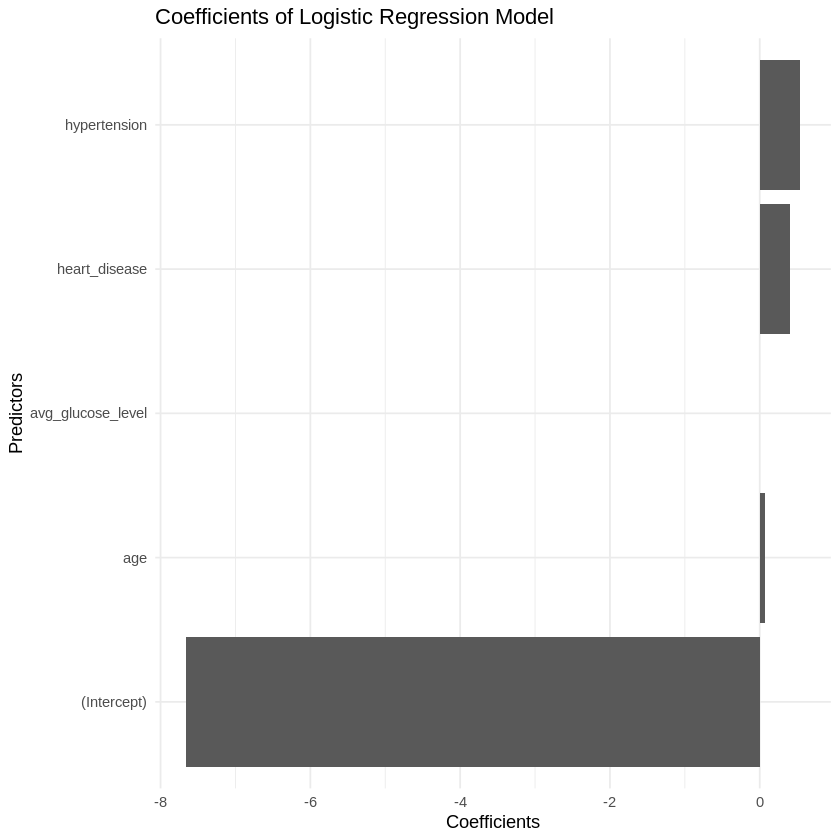

In [28]:
final_model <- model_with_out_gender_smoke_bmi
# Visualization of the Model's Coefficients
coef_df_f <- broom::tidy(final_model)
ggplot(coef_df_f, aes(x = term, y = estimate)) +
  geom_col() +
  coord_flip() +
  labs(title = "Coefficients of Logistic Regression Model",
       x = "Predictors",
       y = "Coefficients") +
  theme_minimal()

5. **Visulize the final model how is it fit the observed data, and is it exceeds the range of probability 0 to 1**

Warning message:
“Use of `stroke_data$age` is discouraged.
ℹ Use `age` instead.”


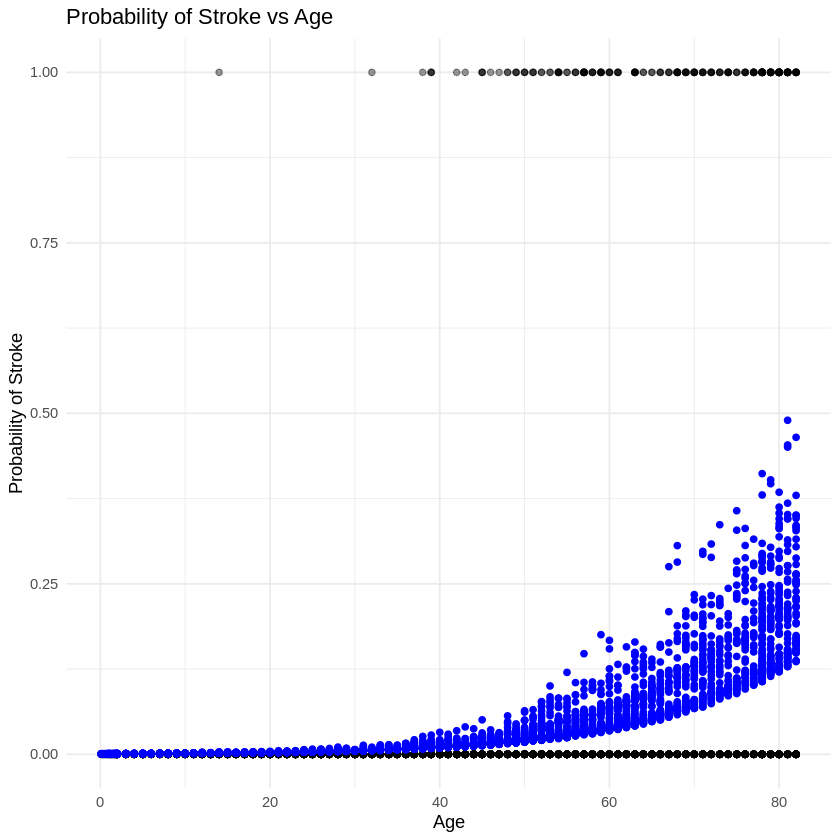

In [32]:
# Predicting probabilities across a range of ages
predicted_probs <- predict(model_with_out_gender_smoke_bmi, 
                           newdata = data.frame(age = stroke_data$age,
                                                hypertension = stroke_data$hypertension,
                                                heart_disease = stroke_data$heart_disease,
                                                avg_glucose_level = stroke_data$avg_glucose_level),
                           type = "response")

# Original scatterplot
ggplot(stroke_data, aes(x = age, y = stroke)) +
  geom_point(alpha = 0.4) +
  geom_point(aes(x = stroke_data$age, y = predicted_probs), color = "blue") +
  labs(title = "Probability of Stroke vs Age",
       x = "Age",
       y = "Probability of Stroke") +
  theme_minimal()

### Comparison of Final Model and Full Model

#### Final Model (`model_with_out_gender_smoke_bmi`)
- **Variables Included:** age, hypertension, heart disease, avg_glucose_level
- **Excluded Variables:** gender, bmi_category, smoking_status
- **Model Characteristics:**
  - Simplified model focusing on core predictors.
  - Excludes potentially confounding or less significant variables like gender, BMI, and smoking status.
  - Potentially more robust to overfitting due to fewer variables.

#### Full Model (`model`)
- **Variables Included:** age, gender, hypertension, heart disease, avg_glucose_level, bmi_category, smoking_status
- **Model Characteristics:**
  - Comprehensive model including a wider range of variables.
  - Accounts for additional factors that might influence the outcome (stroke).
  - More detailed, but potentially more prone to overfitting and complexity.

### Key Differences and Considerations
1. **Complexity vs. Simplicity:** The full model is more complex due to more variables, which can capture more nuances but also risks overfitting. The final model is simpler, potentially more generalizable but might miss some subtleties.
2. **Interpretability:** The final model is easier to interpret due to fewer variables. In contrast, the full model provides a more detailed picture but at the cost of increased complexity in interpretation.
3. **Predictive Power:** The full model might have higher predictive accuracy due to more factors being considered, but this needs to be balanced against the risk of overfitting.
4. **Decision Rationale:** The choice between the two models should be guided by the specific research question, data availability, and the importance of model simplicity versus detail.

In summary, the choice between a final model and a full model hinges on the trade-off between simplicity and comprehensiveness, and the specific objectives of the analysis.
